In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(2,2)  
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))      
        x = self.pool(x)               
        x = F.relu(self.conv2(x))      
        x = self.pool(x)               
        x = x.view(-1, 16*4*4)         
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)

batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 3 
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        out = model(images)
        _, preds = torch.max(out, dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

accuracy = 100.0 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1/3: 100%|██████████| 938/938 [00:04<00:00, 207.60it/s]


Epoch 1: Loss = 0.6260


Epoch 2/3: 100%|██████████| 938/938 [00:04<00:00, 227.93it/s]


Epoch 2: Loss = 0.1227


Epoch 3/3: 100%|██████████| 938/938 [00:04<00:00, 224.89it/s]


Epoch 3: Loss = 0.0838
Test Accuracy: 97.18%


In [4]:
test_images, test_labels = next(iter(test_loader))
test_image = test_images[0].unsqueeze(0).to(device)  
true_label = test_labels[0].item()
print("Изначальный класс:", true_label)

noise = torch.zeros_like(test_image, requires_grad=True) 

target_class = (true_label + 1) % 10
print("Целевой класс:", target_class)

learning_rate = 0.1
steps = 30  
noise_optimizer = optim.SGD([noise], lr=learning_rate)

model.eval()

for step in range(steps):
    noise_optimizer.zero_grad()
    
    adv_image = test_image + noise
    
    adv_image = torch.clamp(adv_image, 0, 1)
    
    out = model(adv_image)
    
    target_tensor = torch.tensor([target_class], device=device)
    loss = F.cross_entropy(out, target_tensor)
    
    loss.backward()
    noise_optimizer.step()
    
    if (step+1) % 5 == 0:
        print(f"Step {step+1}/{steps}, Loss = {loss.item():.4f}")

with torch.no_grad():
    adv_image = torch.clamp(test_image + noise, 0, 1)

Изначальный класс: 7
Целевой класс: 8
Step 5/30, Loss = 3.8861
Step 10/30, Loss = 0.5749
Step 15/30, Loss = 0.2628
Step 20/30, Loss = 0.1722
Step 25/30, Loss = 0.1164
Step 30/30, Loss = 0.0854


Исходная метка: 7, Предсказание на зашумленном изображении: 8 (Целевой класс: 8)


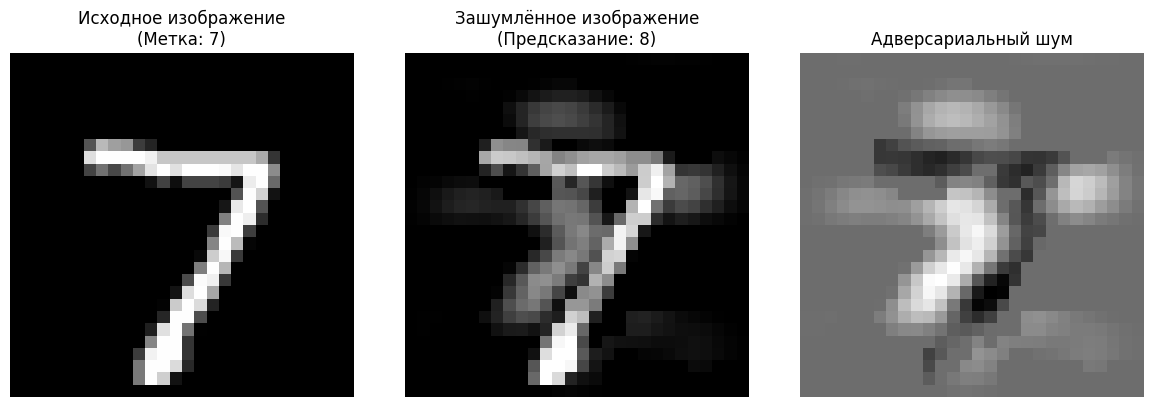

In [7]:
with torch.no_grad():
    out_final = model(adv_image)
    pred_label = torch.argmax(out_final, dim=1).item()

print(f"Исходная метка: {true_label}, Предсказание на зашумленном изображении: {pred_label} (Целевой класс: {target_class})")

orig_img = test_image.squeeze().cpu().numpy()
noise_img = noise.squeeze().detach().cpu().numpy()
adv_img   = adv_image.squeeze().cpu().numpy()

diff = adv_img - orig_img

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.imshow(orig_img, cmap='gray')
plt.title(f"Исходное изображение\n(Метка: {true_label})", fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(adv_img, cmap='gray')
plt.title(f"Зашумлённое изображение\n(Предсказание: {pred_label})", fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(diff, cmap='gray')
plt.title("Адверсариальный шум", fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()